## **1.1 Descarga de datos**

In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

In [2]:
# Descargamos el corpus de datos. En este caso serán las reviews de
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/Grocery.json.gz --no-check-certificate

--2023-08-01 21:03:23--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/Grocery.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 21203355 (20M) [application/x-gzip]
Saving to: ‘Grocery.json.gz’

Grocery.json.gz     100%[===================>]  20.22M  86.4MB/s    in 0.2s    

2023-08-01 21:03:23 (86.4 MB/s) - ‘Grocery.json.gz’ saved [21203355/21203355]



In [3]:
# Descomprimimos con gzip

data = []
with gzip.open('Grocery.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

In [4]:
# largo total de la lista, este numero es igual al numero total de productos
print(f"La cantidad de reviews es: {len(data)}")

# primer elemento de la lista
print(f"Primer elemento de la lista: {data[0]}")

La cantidad de reviews es: 170499
Primer elemento de la lista: {'overall': 1.0, 'verified': False, 'reviewTime': '10 9, 2015', 'reviewerID': 'A3G0W938C7S75X', 'asin': 'B0000532DJ', 'style': {'Size:': ' 2.29 Ounce Bars (Pack of 15)', 'Flavor:': ' Double Chocolate Crisp'}, 'reviewerName': 'bookbuckeye', 'reviewText': 'Buyer beware.  The manufacturer recently shrank these from 2.29oz to 1.59oz.  So, while the description indicates 2.29oz, you may likely receive 1.50oz.\nAlso, I have tried the new ones, and I agree with others that they don\'t taste as good.  For years, these were my "go to" power bar.  Not anymore.  I will be switching.', 'summary': "and I agree with others that they don't taste as good. For years", 'unixReviewTime': 1444348800}


In [5]:
# Pasamos a df Pandas y mostramos los primeros elementos

df_full = pd.DataFrame.from_dict(data)

df_clean = pd.DataFrame(df_full[['overall','reviewText']])

print(f"La cantidad de reviews es: {len(df_clean)}")
print(f"Primeros elementos de la lista: {df_clean.head()}")

La cantidad de reviews es: 170499
Primeros elementos de la lista:    overall                                         reviewText
0      1.0  Buyer beware.  The manufacturer recently shran...
1      5.0  What I love about these is the texture and mou...
2      1.0  The product ingredients have completely change...
3      4.0                                 They're alright...
4      5.0  Please brings these back! The new recipe is aw...


In [6]:
# Veamos si existe algun null para eliminarlo:

print(df_clean.isnull().sum())

overall        0
reviewText    78
dtype: int64


In [7]:
# Existen 78 en reviewText, así que eliminaremos esas filas, que son una cantidad despreciable

df_clean = df_clean.dropna().reset_index(drop=True)
print(df_clean.isnull().sum())

overall       0
reviewText    0
dtype: int64


## **1.2 Balanceado**

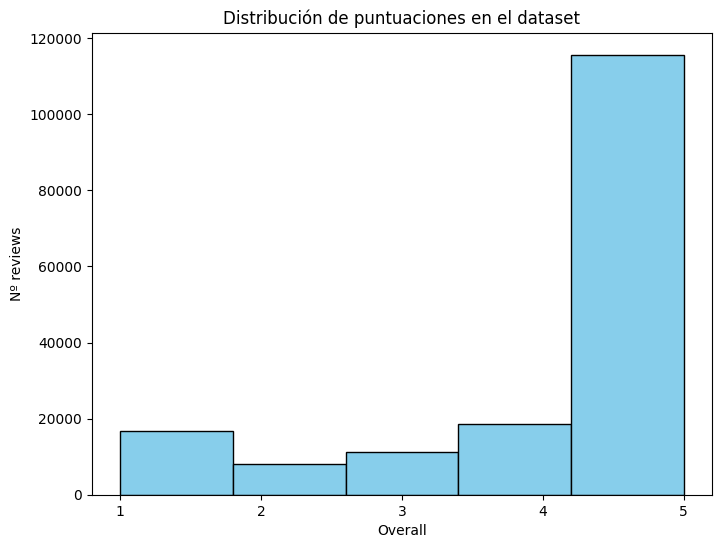

In [8]:
# Veamos ahora cuántas reviews hay por cada estrella:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(df_clean['overall'], bins=5, edgecolor='black', color='skyblue')
plt.xlabel('Overall')
plt.ylabel('Nº reviews')
plt.title('Distribución de puntuaciones en el dataset')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

In [9]:
# Ahora, vamos a separar por estrellas las reviews, para poder tener un corpus de datos balanceado, con la misma cantidad de muestras de cada tipo.
# Para ello, crearemos un df por cada estrella, y después aplicaremos Undersampling para igualar al número más bajo de muestras y así no tener que replicar muestras

resampled_data = {}

# Nº objetivo de samples por estrella
target_num_samples = df_clean['overall'].value_counts().min()
print(f"Mínimo de muestras por clase: {target_num_samples}")

df_balanced = pd.DataFrame(columns=['overall', 'reviewText'])

# Extracción de la misma cantidad de samples (target_num_samples), de cada estrella
for star in [1.0, 2.0, 3.0, 4.0, 5.0]:
  star_reviews = df_clean[df_clean['overall'] == star]
  sampled_reviews = star_reviews.sample(n=target_num_samples, random_state=0)
  print(f"Nº muestras clase {star}: {len(sampled_reviews)}")
  df_balanced = pd.concat([df_balanced, sampled_reviews])

# Mezcla del df para que no estén las reviews ordenadas
df_balanced = df_balanced.sample(frac=1, random_state=0).reset_index(drop=True)

Mínimo de muestras por clase: 8153
Nº muestras clase 1.0: 8153
Nº muestras clase 2.0: 8153
Nº muestras clase 3.0: 8153
Nº muestras clase 4.0: 8153
Nº muestras clase 5.0: 8153


Vemos que estamos dejando bastantes muestras fuera (hay 115.731 muestras de la clase 5, y vamos a quedarnos solo 8.153 de cada tipo). Dependiendo de si está muy desbalanceado el dataset, debemos valorar si usar este método u otro. Sin embargo, en el contexto de la práctica, 8.153 * 5 muestras, serán suficientes.



In [10]:
print(f"El nuevo df balanceado tiene un total de {len(df_balanced)} filas")
print(f"Primeros elementos de la lista: {df_balanced.head()}")

El nuevo df balanceado tiene un total de 40765 filas
Primeros elementos de la lista:    overall                                         reviewText
0      4.0  It's got a lot more kick than what you'll find...
1      2.0  Cookies seemed a little old, did not come with...
2      1.0  These caramels are grainy and tasteless. They ...
3      4.0                                 very good , strong
4      4.0  Not as good as home made from scratch, but not...


## **1.3 Etiquetado**

Una vez balanceado del dataset, vamos a **etiquetar como positivas y negativas**, siendo **<=3 negativas y >3 positivas** (es cierto que habrá más negativas que positivas en este caso, pero será una relación 60-40, mucho menor y más manejable que con el dataset inicial).

In [11]:
# Vamos a conservar df_balanced y trabajaremos sobre un nuevo df por si más adelante decidimos hacer algún cambio
df_balanced_sent = df_balanced.copy()
df_balanced_sent['sentiment'] = df_balanced['overall'].apply(lambda x:0 if x <= 3 else 1)

df_balanced_sent.drop(columns=['overall'], inplace=True)


## **1.4 Cardinalidad**

Vamos a ver la cardinalidad del vocabulario, antes de proceder a separar positivos y negativos

In [12]:
# Veamos la longitud promedio de las reviews, la más larga y la más corta

review_lengths = df_balanced_sent['reviewText'].apply(lambda x: len(x.split()))

short_rew = df_balanced_sent.loc[review_lengths.idxmin(), 'reviewText']
long_rew = df_balanced_sent.loc[review_lengths.idxmax(), 'reviewText']

print(f"Longitud promedio de las reviews: {review_lengths.mean()}")
print(f"Review más corta: {len(short_rew)} : {short_rew}")
print(f"Review más larga: {len(long_rew)} : {long_rew}")

Longitud promedio de las reviews: 40.66385379614866
Review más corta: 7 : Filling
Review más larga: 8005 : Canola oil was developed through hybridization of rape seed.

Canola is a made-up word which stands for "Canadian oil low acid", and is a genetically modified product.

It is a Canadian invention that is backed by the government.

It's a cheap product to manufacture, and many processed or packaged foods contain canola oil.

Canola oil was first bred in the early 1970s as a natural oil, but in 1995 Monsanto created a genetically modified version of canola oil. By 2009, 90% of the Canadian crop was genetically engineered and as of 2005, 87% of canola grown in the United States was genetically modified.

Facts You Should Know About Canola Oil >>>>>>>>>>>

The name of canola oil was originally LEAR (Low Erucic Acid Rapeseed) but for marketing purposes was changed to canola oil. This word was derived from the combination of the phrase, "Canadian oil." Canola oil is a much more appealin

In [13]:
!pip install nltk

In [14]:
# Veamos la cardinalidad del corpus

import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt') # punkt tokenizer es el responable de tokenizar por palabras

# Tokenizamos
tokenized_text = [word_tokenize(text.lower()) for text in df_balanced_sent['reviewText']]

# Convertimos a minúsculas
tokenized_text = [[word.lower() for word in tokens] for tokens in tokenized_text]

# Creamos un conjunto con todas las palabras únicas del vocabulario
vocabulario = set(token for tokens in tokenized_text for token in tokens)

# Tamaño del vocabulario
cardinality = len(vocabulario)

print(f"La cardinalidad del vocabulario es: {cardinality}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


La cardinalidad del vocabulario es: 34139


Vemos que tenemos una cardinalidad de 34.139 palabras diferentes. Veamos las más frecuentes ahora.

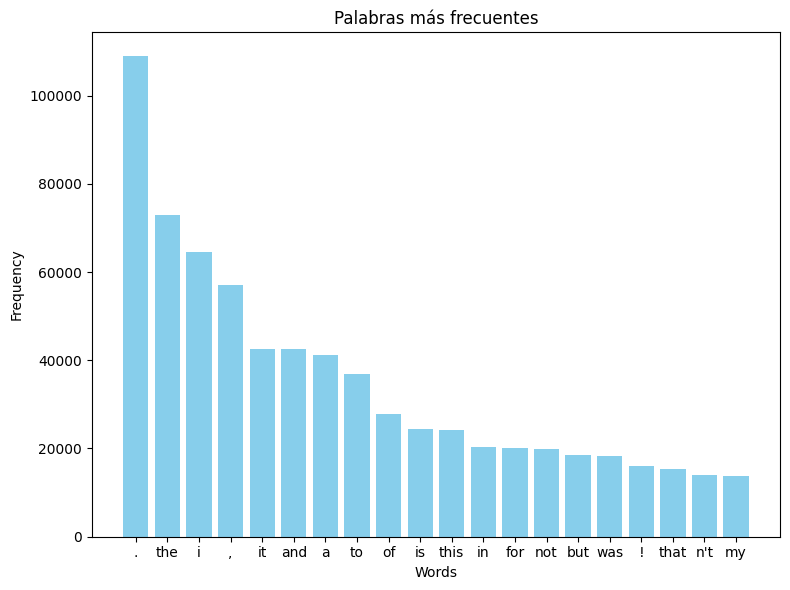

In [15]:
# Contamos la frecuencia
word_freq = nltk.FreqDist(token for tokens in tokenized_text for token in tokens)

common_words = word_freq.most_common(20)

plt.figure(figsize=(8, 6))
plt.bar([word[0] for word in common_words], [word[1] for word in common_words], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Palabras más frecuentes')
plt.tight_layout()
plt.show()

## **1.5 Wordcloud**

Vemos que los tokens más comunes muy probablemente no nos sirvan de nada, ya que hasta incluyen signos de puntuación.

Visualicemos una **nube de palabras** para ver la información de una forma más gráfica:



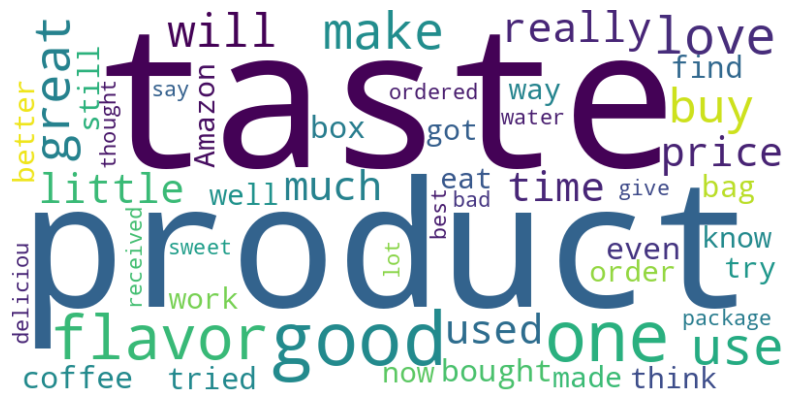

In [16]:
from wordcloud import WordCloud

# Concatenamos todas las reviews en all_reviews_text
all_reviews_text = ' '.join(df_balanced_sent['reviewText'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=50).generate(all_reviews_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Veamos **una nube de palabras para el sentimiento positivo** y** otra para el negativo**, para ver cuales son las palabras más utilizadas según su sentimiento. Esa puede ser una información muy importante a la hora de comprender el sentimiento:

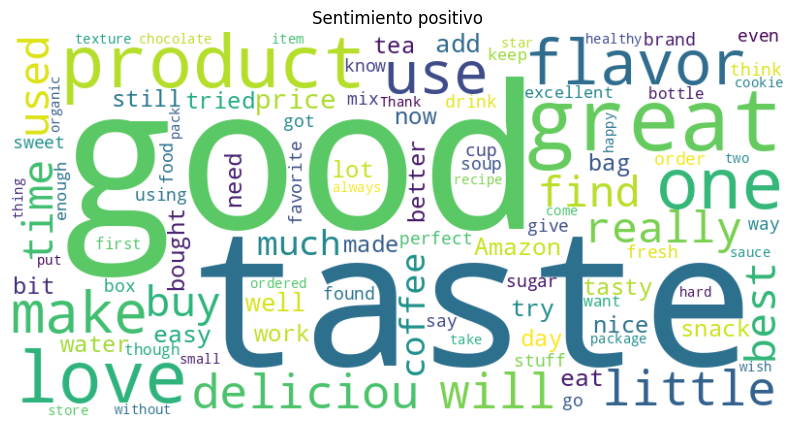

In [17]:
# Positivo

from wordcloud import WordCloud

# Concatenamos todas las reviews en all_reviews_text
all_reviews_text = ' '.join(df_balanced_sent[df_balanced_sent['sentiment'] == 1]['reviewText'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100).generate(all_reviews_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimiento positivo")
plt.show()

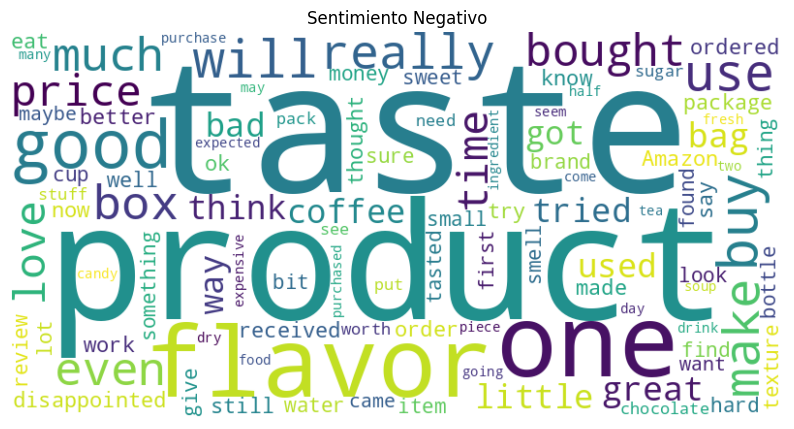

In [18]:
# Negativo

from wordcloud import WordCloud

# Concatenamos todas las reviews en all_reviews_text
all_reviews_text = ' '.join(df_balanced_sent[df_balanced_sent['sentiment'] == 0]['reviewText'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100).generate(all_reviews_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimiento Negativo")
plt.show()

Lo cierto es que **las palabras que más se repiten, son similares tanto en positivo como en negativo**, esto nos puede indicar que no son útiles para nuestro estudio. Sin embargo, **en el sentimiento negativo se aprecian palabras de desagrado y de duda**, que seguramente sean las que marquen la diferencia, mientras que **en el positivo, se ven palabras de felicidad y de gusto**.

## **1.6 N-grams**

Veamos ahora qué sucede con los n-grams:

In [19]:
from nltk.collections import Counter
from nltk.util import ngrams

bigrams_ = ngrams([word for review in tokenized_text for word in review], 2)
trigrams_ = ngrams([word for review in tokenized_text for word in review], 3)

bg_freq = Counter(bigrams_).most_common(20)
tg_freq = Counter(trigrams_).most_common(20)


('.', 'i'): 23569
(',', 'but'): 8341
('.', 'the'): 8253
('.', 'it'): 6969
('of', 'the'): 5933
(',', 'and'): 5468
('in', 'the'): 5137
('it', "'s"): 4933
(',', 'i'): 4790
('.', 'this'): 4180
('it', 'is'): 4096
('i', 'was'): 4038
('it', 'was'): 4029
('!', '!'): 3993
('i', 'have'): 3830
('do', "n't"): 3818
('this', 'is'): 3558
('it', '.'): 3521
('if', 'you'): 2974
('.', 'they'): 2969


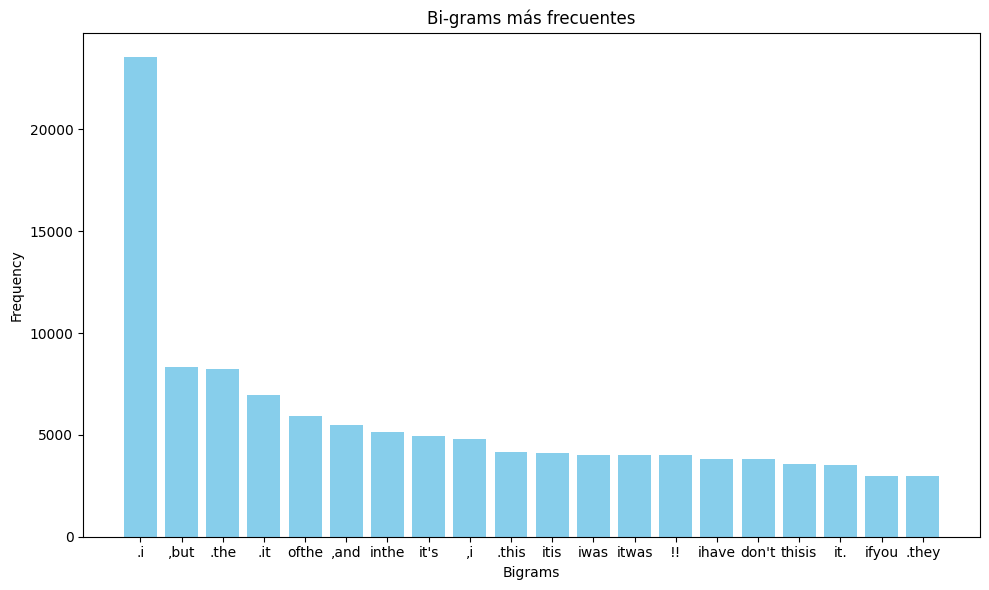

In [20]:
bg_words = [''.join(bigram) for bigram, freq in bg_freq]
bg_frequencies = [freq for bigram, freq in bg_freq]

for bigram, freq in bg_freq:
    print(f"{bigram}: {freq}")

plt.figure(figsize=(10, 6))
plt.bar(bg_words, bg_frequencies, color='skyblue')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title('Bi-grams más frecuentes')
plt.tight_layout()
plt.show() # COMENTAR Y HACER TRIGRAMS

('!', '!', '!'): 1915
('i', 'do', "n't"): 1668
('.', 'it', "'s"): 1600
('.', 'i', 'was'): 1449
('.', 'i', 'have'): 1429
(',', 'but', 'i'): 1428
('.', 'this', 'is'): 1422
('.', 'it', 'is'): 1259
('.', 'if', 'you'): 1089
('.', 'i', "'m"): 1058
('.', 'it', 'was'): 966
('.', 'i', 'am'): 932
('.', 'i', 'do'): 931
('.', 'i', 'would'): 926
('i', 'did', "n't"): 918
(',', 'but', 'it'): 908
('.', 'they', 'are'): 847
('it', '.', 'i'): 843
('.', 'i', 'love'): 808
('a', 'lot', 'of'): 781


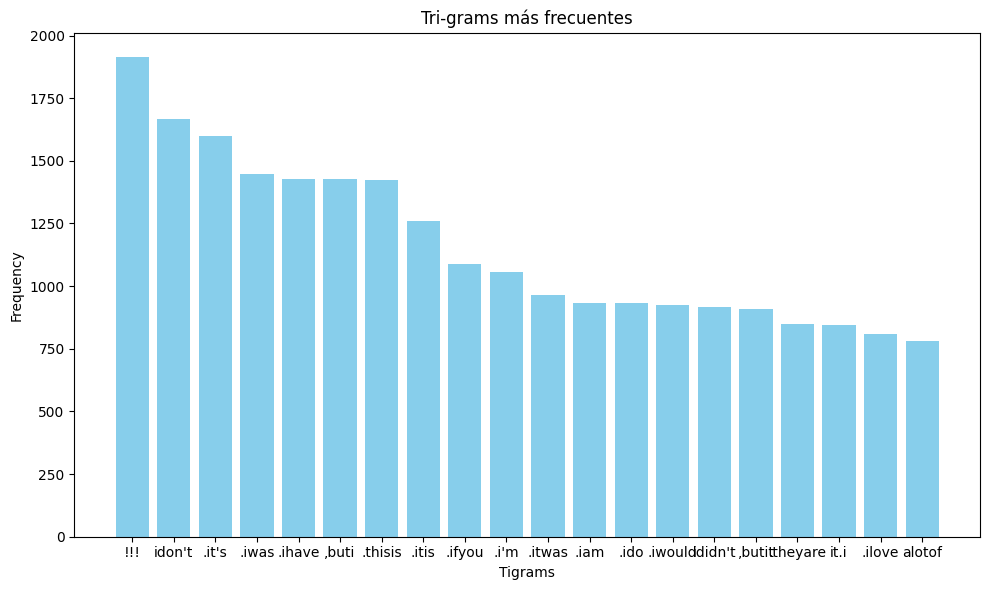

In [21]:
tg_words = [''.join(tigram) for tigram, freq in tg_freq]
tg_frequencies = [freq for tigram, freq in tg_freq]

for tigram, freq in tg_freq:
    print(f"{tigram}: {freq}")

plt.figure(figsize=(10, 6))
plt.bar(tg_words, tg_frequencies, color='skyblue')
plt.xlabel('Tigrams')
plt.ylabel('Frequency')
plt.title('Tri-grams más frecuentes')
plt.tight_layout()
plt.show()

Parece bastante evidente que hay muchas **stop words** que hay que eliminar en el pre-procesado (notebook 2)

## **1.7 Visualización word embeddings**

Ahora, vamos arealizar la Visualización en 2 dimensiones de algunos word embeddings con Word2Vec

In [22]:
# Vamos a entrenar el modelo Word2Vec con el corpus de texto actual. Después, seleccionaremos algunas palabras de interés y mostraremos las más similares en un gráfico de dispersión.

from gensim.models import Word2Vec

model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, sg=0)

In [23]:
# Vamos a seleccionar las palabras de interés de las nubes de palabas que hicimos más arriba

target_words=['taste', 'good', 'product', 'bad', 'best']

# Obtenemos las 10 más similares para cada una
similar_words = {}
for word in target_words:
  similar_words[word] = [similar_word for similar_word, _ in model.wv.most_similar(word, topn=10)]


In [24]:
# Visualización 2D (usamos PCA para reducción de dimensionalidad)

from sklearn.decomposition import PCA

all_words = target_words + [word for words in similar_words.values() for word in words]
word_vectors = [model.wv[word] for word in all_words]

# Reducción de dimensionalidad
pca = PCA(n_components=2)
word_embeddings_2d = pca.fit_transform(word_vectors)

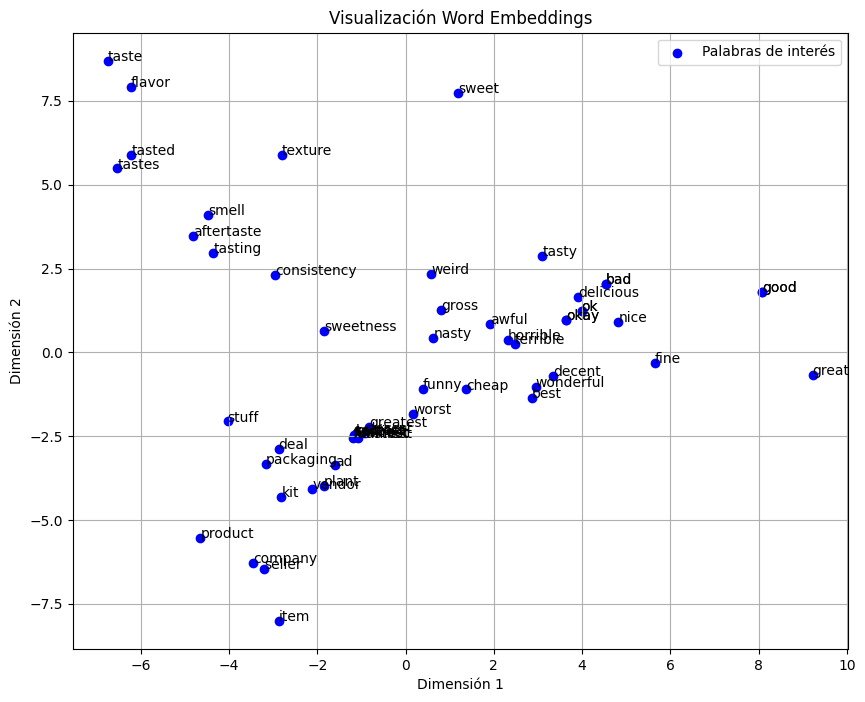

In [25]:
plt.figure(figsize=(10, 8))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], marker='o', color='b', label='Palabras de interés')

for i, word in enumerate(all_words):
  plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]), fontsize=10)
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.title('Visualización Word Embeddings')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Por último, vamos a guardar el dataset con el que trabajaremos en la parte de preprocesado.

from google.colab import drive

drive.mount('/content/drive')

df_balanced_sent.to_csv('/content/drive/MyDrive/NLP/df_balanced_sent.csv', index=False)

Mounted at /content/drive


Para interpretar este gráfico de **word embeddings**, hay que tener en cuenta que las palabas estarán más próximas entre sí si tienen una **mayor relación semántica**. Por ejemplo, item, company y product, están cerca en un mismo area. Taste, flavor, smell, también estan próximas entre sí.

De este modo, vemos cómo se relacionan entre sí, y cómo el modelo agrupa las palabras con **significados similares**, lo que nos ayuda a entender desde su **relación semántica el sentimiento**.

## **1.8 Conclusiones**

En esta Exploración del corpus, podemos apreciar algunas cosas.
En primer lugar, hemos podido identificar las palabras (también las emociones, temáticas, experiencias...) que **diferencian un sentimiento positivo de uno negativo** en las reviews de Grocery.
Además, hemos identificado **palabras comunes**, que no nos aportarán valor (por ejemplo, Product, es una de las palabras más usuales en ambos casos, pero resulta evidente ya que estamos hablando de productos).
También hemos visto claramente la necesidad de **eliminar stop words**, así como **signos de puntuación que abundan**.

Podríamos ahondar algo más con un análisis más avanzado, por ejemplo, identificando **tópicos** o temas principales del corpus. También usar spaCy para **identificar y clasificar entidades nombradas**, e incluso utilizar algún **diccionario de palabras emocionales** para determinar la presencia e intensidad de diferentes emociones. También podríamos representar la dispersión léxica, pero no lo veo de tanta utilidad al tratarse de un gran número de textos muy pequeños como son las reviews. Como esto escapa al propósito de la práctica, por ahora dejaremos el **EDA** así, y en caso de tener tiempo trataremos de profundizar y explorar alguna de estas técnicas.